# Class Imbalance Mitigation for Enhanced IDS Dataset
### Supporting Praxis: *Leveraging AutoML for Advanced Network Traffic Analysis and Intrusion Detection by Enhancing Security with a Multi-Feature IDS Dataset*

**Author:** Chibuike Abana, Doctoral Candidate, George Washington University  
**Date:** March 14, 2025  
**Purpose:** This script addresses class imbalance within the CSE-CIC-IDS2018-derived dataset using a multi-phase resampling approach, including undersampling, SMOTE, and SMOTEENN. These techniques improve minority class representation to enhance IDS model performance and fairness.

**License:** MIT License  
Released under the MIT License. You are free to use, modify, and distribute this code with appropriate credit. Refer to the accompanying `LICENSE` file for full details.

## Importing libraries needed for the handling class imbalance

In [1]:
# installing the imblearn
!conda install -c conda-forge imbalanced-learn -y

Retrieving notices: done
Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imbalanced-learn-0.13.0    |     pyhd8ed1ab_0         141 KB  conda-forge
    sklearn-compat-0.1.3       |     pyhd8ed1ab_0          22 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         163 KB

The following NEW packages will be INSTALLED:

  imbalanced-learn   conda-forge/noarch::imbalanced-learn-0.13.0-pyhd8ed1ab_0 
  

In [2]:
# importing libraries
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import seaborn as sns
import matplotlib.pyplot as plt

## Importing  training dataset

In [ ]:
# USING only training dataset for mitigating imbalance 'training.csv'
training_df = pd.read_csv("s3://final-praxis/Dataset/output-path/new-processed-data/training.csv")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [4]:
print("Class distribution before Balancing")
print(training_df["Label"].value_counts())

Class distribution before Balancing
Benign                      33349544
DoS Hulk                     1442528
DDoS-HOIC                     865834
DDoS-LOIC-HTTP                231462
Botnet Ares                   114337
SSH-BruteForce                 75358
DoS GoldenEye                  18048
DoS Slowloris                   6792
DDoS-LOIC-UDP                   2022
Web Attack - Brute Force         105
Web Attack - XSS                  90
Name: Label, dtype: int64


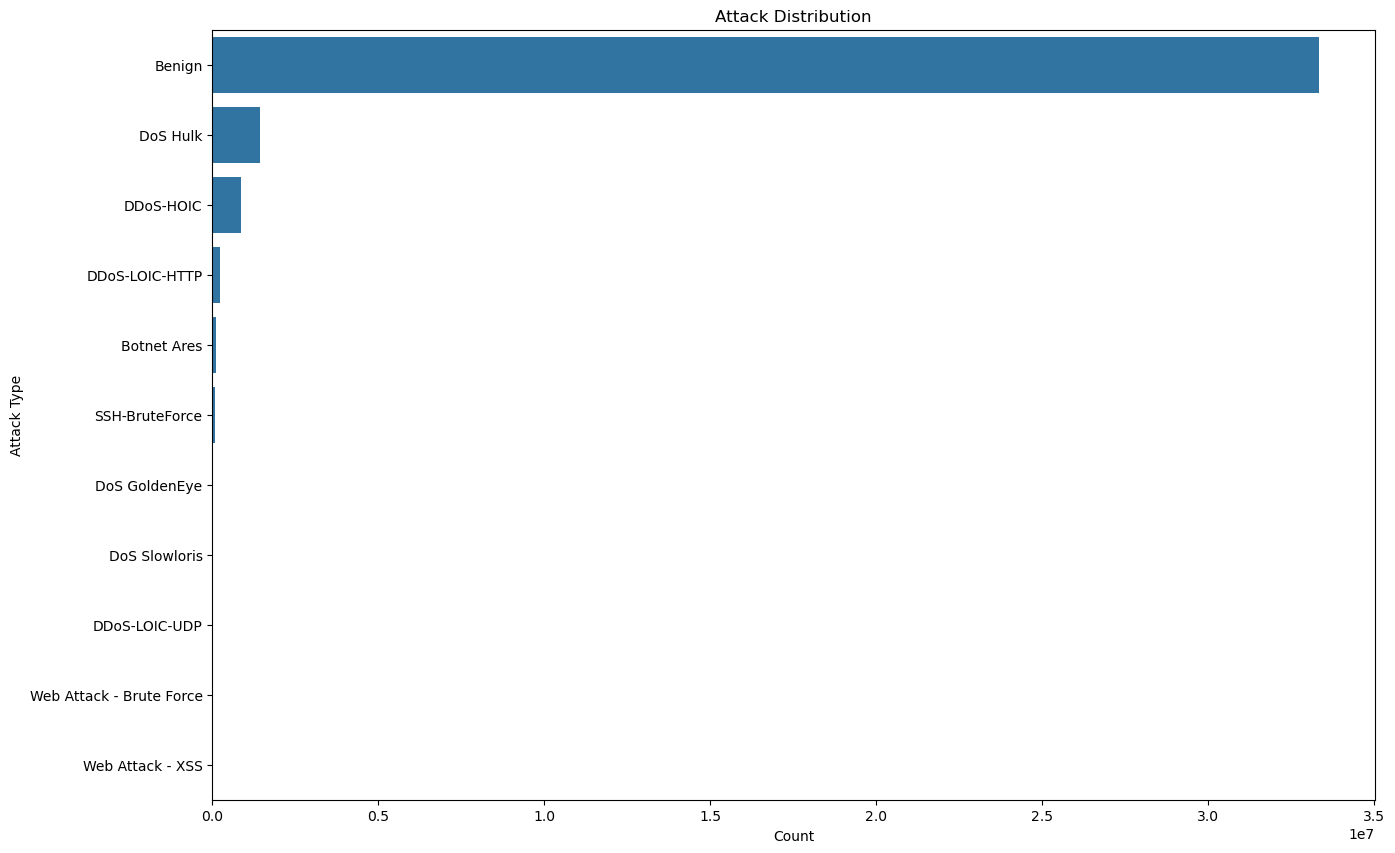

In [5]:
# the 'Label' column contains attack types
plt.figure(figsize=(15, 10))
sns.countplot(y=training_df['Label'], order=training_df['Label'].value_counts().index)
plt.title('Attack Distribution')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.show()

In [6]:
training_df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Total TCP Flow Time,Label
0,6,1179,5,5,161,488,161,0,32.2,72.001389,...,0.0,0.0,0,0,0.0,0.000000e+00,0,0,1179,Benign
1,17,65832,2,2,86,118,43,43,43.0,0.000000,...,0.0,0.0,0,0,0.0,0.000000e+00,0,0,0,Benign
2,6,937,5,5,161,488,161,0,32.2,72.001389,...,0.0,0.0,0,0,0.0,0.000000e+00,0,0,937,Benign
3,6,21342395,1,4,0,0,0,0,0.0,0.000000,...,3155749.0,0.0,3155749,3155749,9093323.0,4.374751e+06,12186739,5999907,21342395,Benign
4,6,2027836,8,7,1128,1581,661,0,141.0,222.623321,...,0.0,0.0,0,0,0.0,0.000000e+00,0,0,2027836,Benign


In [11]:
training_data_df = training_df

# Handling imbalance

> Two strategy used
    - Undersampling the majority to a benchmark 
    - Oversample the minority with SMOTE and SMOTEEN (rare classes <110)

In [ ]:
# --------------------------------------------------
# Undersample "Benign" to 1,000,000 samples.
# --------------------------------------------------
X = training_data_df.drop('Label', axis=1)
y = training_data_df['Label']

# Reduce the dominant "Benign" class while keeping its diversity.
under_sampler = RandomUnderSampler(
    sampling_strategy={'Benign': 1500000},
    random_state=42
)
X_under, y_under = under_sampler.fit_resample(X, y)

# Get class counts after undersampling
counts_after_undersample = y_under.value_counts()
benign_count = counts_after_undersample['Benign']  # Expected: 1,000,000

# ---------------------------------------------------
# parameters for oversampling minority classes.
# ---------------------------------------------------
target_ratio = 0.1          # Target: 10% of "Benign" (100,000 samples)
target_count = int(benign_count * target_ratio)
max_cap = 50000            # Increased cap for better representation
min_sample_threshold = 110 # benchmark for very rare minority class
min_target = 21000         # Higher target for rare classes

# ---------------------------------------------------
# dictionary specifying the final desired counts per class.
# ---------------------------------------------------
sampling_strategy_dict = {}

for cls, current_count in counts_after_undersample.items():
    if cls == 'Benign':
        # Keep the "Benign" class as is.
        sampling_strategy_dict[cls] = current_count

        # For extremely underrepresented classes, apply a fixed modest target.
    elif current_count < min_sample_threshold:
        # Only oversample if below the fixed minimum target.
        sampling_strategy_dict[cls] = min_target if current_count < min_target else current_count
    else:
        # For classes with at least min_sample_threshold samples, target the ratio-based count,
        ratio_target = target_count
        if current_count < ratio_target:
            # Only cap at 50,000 if below it; otherwise, keep original count
            sampling_strategy_dict[cls] = min(ratio_target, max_cap) if current_count < max_cap else current_count
        else:
            # If the class already meets or exceeds the target, leave it unchanged.
            sampling_strategy_dict[cls] = current_count

print("Final Sampling Strategy:\n", sampling_strategy_dict)

# ---------------------------------------------------
# SMOTEENN and SMOTE to oversample the minority classes according to our strategy.
# ---------------------------------------------------


smoteenn = SMOTEENN(sampling_strategy={k: v for k, v in sampling_strategy_dict.items() if v == min_target}, random_state=42)
X_rare_bal, y_rare_bal = smoteenn.fit_resample(X_under, y_under)

smote = SMOTE(sampling_strategy={k: v for k, v in sampling_strategy_dict.items() if v != min_target}, random_state=42)
X_bal, y_bal = smote.fit_resample(X_rare_bal, y_rare_bal)

Final Sampling Strategy:
 {'Benign': 1500000, 'DoS Hulk': 1442528, 'DDoS-HOIC': 865834, 'DDoS-LOIC-HTTP': 231462, 'Botnet Ares': 114337, 'SSH-BruteForce': 75358, 'DoS GoldenEye': 50000, 'DoS Slowloris': 50000, 'DDoS-LOIC-UDP': 50000, 'Web Attack - Brute Force': 21000, 'Web Attack - XSS': 21000}


In [13]:
# check the distribution
print("Final Distribution:\n", pd.Series(y_bal).value_counts())

Final Distribution:
 Benign                      1500000
DoS Hulk                    1442528
DDoS-HOIC                    865834
DDoS-LOIC-HTTP               231462
Botnet Ares                  114337
SSH-BruteForce                75358
DDoS-LOIC-UDP                 50000
DoS GoldenEye                 50000
DoS Slowloris                 50000
Web Attack - XSS              20894
Web Attack - Brute Force      20812
Name: Label, dtype: int64


In [14]:
# Concating the  balanced data
balanced_df = pd.concat([X_bal, y_bal], axis=1)

In [ ]:
# Export balanced training set to CSV
data_output_path = 's3://final-praxis/Dataset/output-path/new-processed-data'
balanced_df.to_csv(f'{data_output_path}/balanced_training.csv', index=False)
print("Uploaded successfully to S3 bucket")

print("Balanced dataset saved to balanced_training.csv.")
print("New class distribution:\n", y_bal.value_counts())

Uploaded successfully to S3 bucket
Balanced dataset saved to balanced_training.csv.
New class distribution:
 Benign                      1500000
DoS Hulk                    1442528
DDoS-HOIC                    865834
DDoS-LOIC-HTTP               231462
Botnet Ares                  114337
SSH-BruteForce                75358
DDoS-LOIC-UDP                 50000
DoS GoldenEye                 50000
DoS Slowloris                 50000
Web Attack - XSS              20894
Web Attack - Brute Force      20812
Name: Label, dtype: int64


In [ ]:
#  Original distribution
original_counts = training_data_df['Label'].value_counts()

#  Balanced distribution
balanced_counts = balanced_df['Label'].value_counts()

# Compute imbalance ratio: largest class / smallest class
original_imbalance_ratio = original_counts.max() / original_counts.min()
balanced_imbalance_ratio = balanced_counts.max() / balanced_counts.min()

print("=== Original Class Distribution ===")
print(original_counts)
print(f"Original imbalance ratio (largest / smallest): {original_imbalance_ratio:.2f}")
print()
print("\n=== Balanced Class Distribution ===")
print(balanced_counts)
print(f"Balanced imbalance ratio (largest / smallest): {balanced_imbalance_ratio:.2f}")

=== Original Class Distribution ===
Benign                      33349544
DoS Hulk                     1442528
DDoS-HOIC                     865834
DDoS-LOIC-HTTP                231462
Botnet Ares                   114337
SSH-BruteForce                 75358
DoS GoldenEye                  18048
DoS Slowloris                   6792
DDoS-LOIC-UDP                   2022
Web Attack - Brute Force         105
Web Attack - XSS                  90
Name: Label, dtype: int64
Original imbalance ratio (largest / smallest): 370550.49


=== Balanced Class Distribution ===
Benign                      1500000
DoS Hulk                    1442528
DDoS-HOIC                    865834
DDoS-LOIC-HTTP               231462
Botnet Ares                  114337
SSH-BruteForce                75358
DDoS-LOIC-UDP                 50000
DoS GoldenEye                 50000
DoS Slowloris                 50000
Web Attack - XSS              20894
Web Attack - Brute Force      20812
Name: Label, dtype: int64
Balanced imbal

/tmp/ipykernel_78854/1928869239.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_78854/1928869239.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


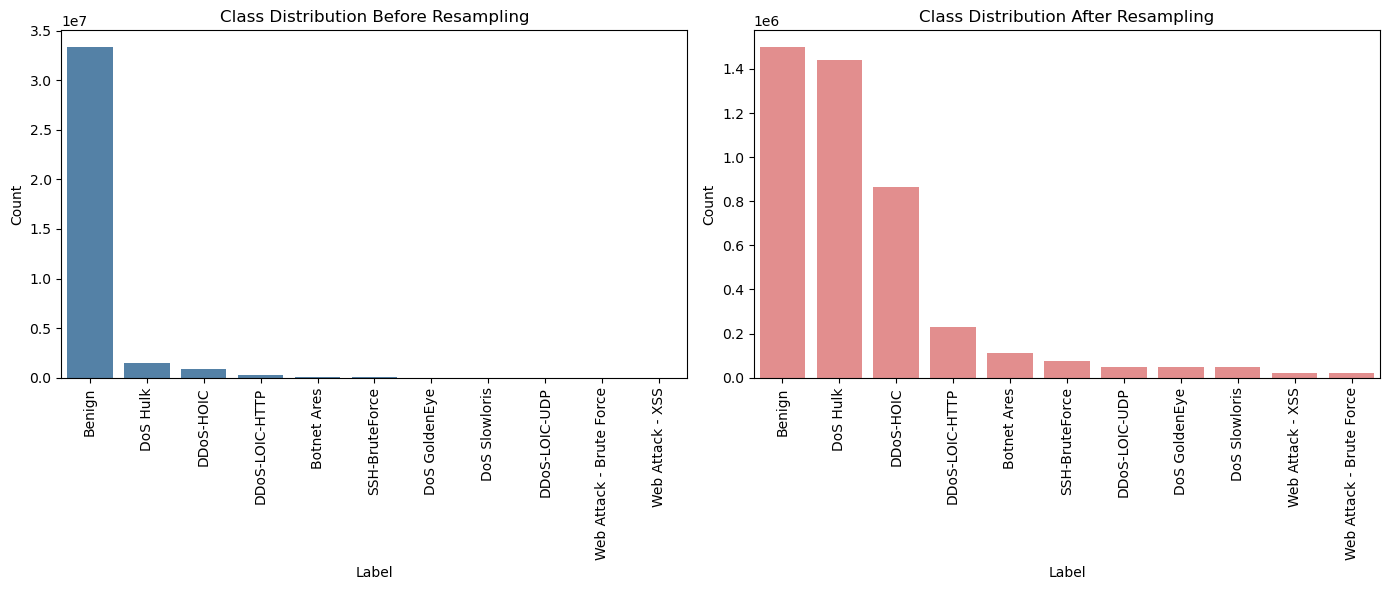

In [18]:
# Convert the value_counts Series to DataFrame for easy plotting
original_df = original_counts.reset_index()
original_df.columns = ['Label', 'Count']

balanced_df_counts = balanced_counts.reset_index()
balanced_df_counts.columns = ['Label', 'Count']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=False)

# Bar chart: Before Resampling
sns.barplot(x='Label', y='Count', data=original_df, ax=axes[0], color='steelblue')
axes[0].set_title("Class Distribution Before Resampling")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# Bar chart: After Resampling
sns.barplot(x='Label', y='Count', data=balanced_df_counts, ax=axes[1], color='lightcoral')
axes[1].set_title("Class Distribution After Resampling")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

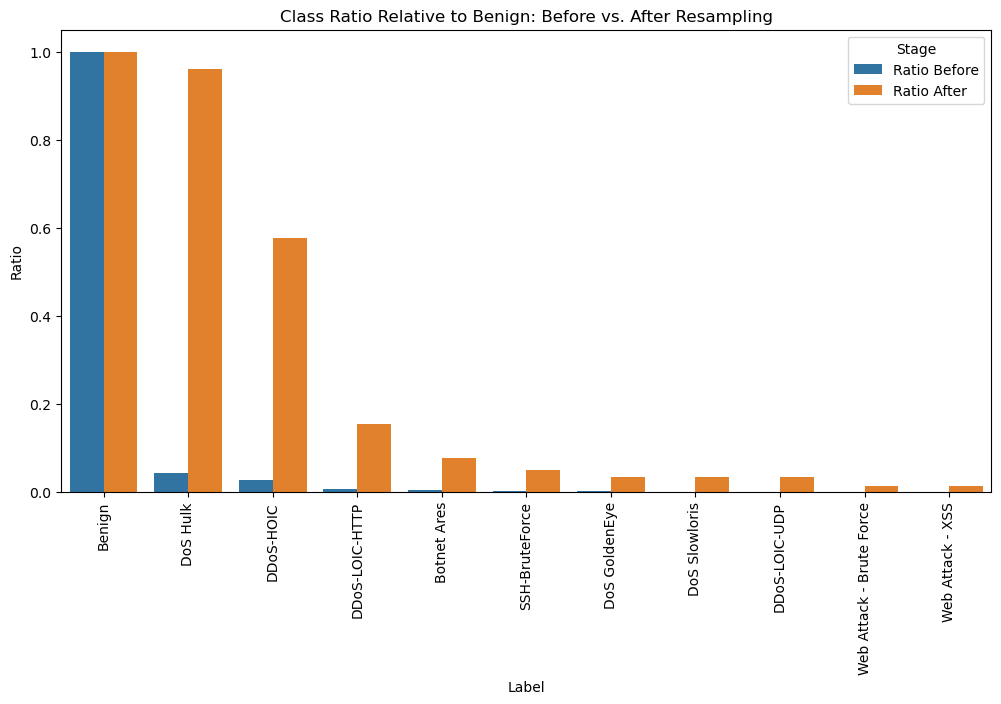

In [19]:
import numpy as np

# For each class, compute ratio vs. "Benign" for original and balanced
class_labels = original_counts.index.tolist()

# Original ratio = (class_count / benign_count)
benign_count_orig = original_counts.get('Benign', 1)  # avoid division by zero
ratios_before = [original_counts[label] / benign_count_orig for label in class_labels]

# Balanced ratio
benign_count_bal = balanced_counts.get('Benign', 1)
ratios_after = [balanced_counts[label] / benign_count_bal for label in class_labels]

# Create a DataFrame to hold these ratios
ratio_df = pd.DataFrame({
    'Label': class_labels,
    'Ratio Before': ratios_before,
    'Ratio After': ratios_after
})

# Melt for easy grouped bar chart
ratio_melted = ratio_df.melt(id_vars='Label', var_name='Stage', value_name='Ratio')

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Label', y='Ratio', hue='Stage', data=ratio_melted)
plt.xticks(rotation=90)
plt.title("Class Ratio Relative to Benign: Before vs. After Resampling")
plt.show()

### Displaying outcomes and SMOTE review


Resampled Class Distribution:
Benign                      1500000
Botnet Ares                  114337
DDoS-HOIC                    865834
DDoS-LOIC-HTTP               231462
DDoS-LOIC-UDP                 50000
DoS GoldenEye                 50000
DoS Hulk                    1442528
DoS Slowloris                 50000
SSH-BruteForce                75358
Web Attack - Brute Force      20812
Web Attack - XSS              20894
Name: Label, dtype: int64


/tmp/ipykernel_78854/2984674684.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


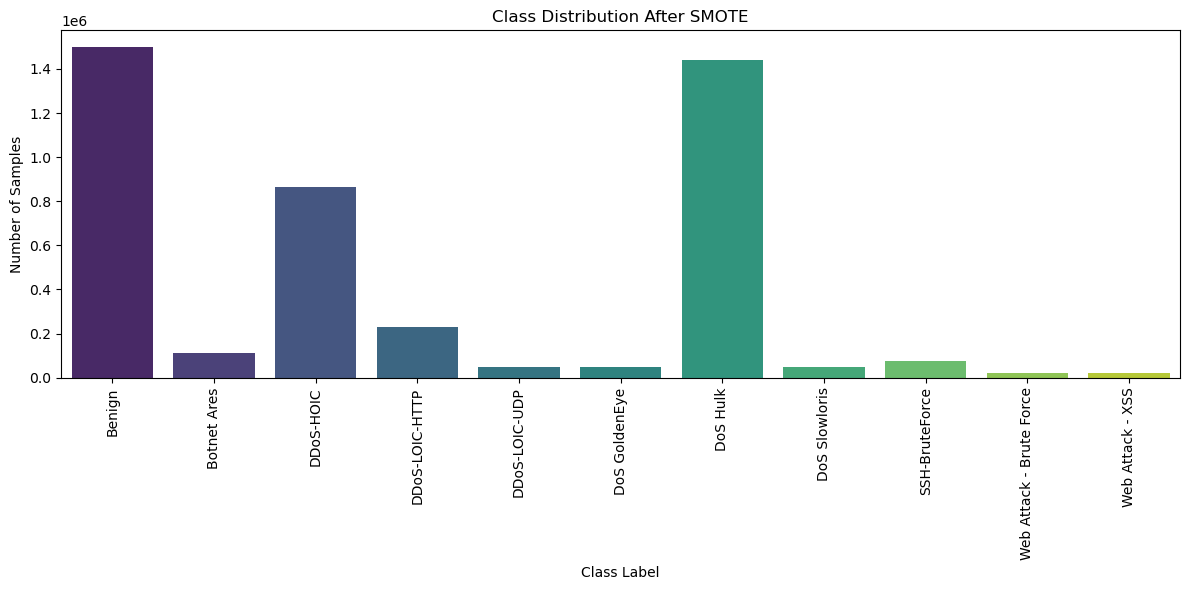

In [20]:
# Check class distribution
class_distribution = balanced_df['Label'].value_counts().sort_index()
print("\nResampled Class Distribution:")
print(class_distribution)

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# End of SMOTE

# reviewing the New Dataset

In [21]:
balanced_df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Total TCP Flow Time,Label
0,6,90304674,14,10,1441,1731,725,0,102.928571,191.148941,...,4197982.0,0.0,4197982,4197982,86106692.0,0.0,86106692,86106692,90304674,Benign
1,6,527689,5,4,373,172,140,0,74.600000,70.283711,...,0.0,0.0,0,0,0.0,0.0,0,0,527689,Benign
2,6,3003576,3,0,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,3003576,Benign
3,6,6442018,8,11,1148,1581,677,0,143.500000,228.129662,...,0.0,0.0,0,0,0.0,0.0,0,0,6442018,Benign
4,17,31891,1,1,35,91,35,35,35.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,Benign


In [22]:
balanced_df.shape

(4421225, 80)

In [23]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4421225 entries, 0 to 4421224
Data columns (total 80 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Protocol                    int64  
 1   Flow Duration               int64  
 2   Total Fwd Packet            int64  
 3   Total Bwd packets           int64  
 4   Total Length of Fwd Packet  int64  
 5   Total Length of Bwd Packet  int64  
 6   Fwd Packet Length Max       int64  
 7   Fwd Packet Length Min       int64  
 8   Fwd Packet Length Mean      float64
 9   Fwd Packet Length Std       float64
 10  Bwd Packet Length Max       int64  
 11  Bwd Packet Length Min       int64  
 12  Bwd Packet Length Mean      float64
 13  Bwd Packet Length Std       float64
 14  Flow Bytes/s                float64
 15  Flow Packets/s              float64
 16  Flow IAT Mean               float64
 17  Flow IAT Std                float64
 18  Flow IAT Max                int64  
 19  Flow IAT Min         

In [24]:
balanced_df.describe()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Total TCP Flow Time
count,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,...,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06,4.421225e+06
mean,6.829809e+00,1.348486e+07,1.317279e+03,9.032019e+00,4.322647e+04,5.308441e+03,3.523108e+02,3.027489e+00,7.494004e+01,1.348823e+02,...,2.345111e+01,2.626456e+05,4.294756e+04,3.143304e+05,2.343136e+05,6.255310e+06,5.250396e+05,6.745044e+06,5.832921e+06,8.887261e+07
std,2.925192e+00,3.186556e+07,1.285885e+04,1.475699e+02,4.127837e+05,2.096153e+05,9.663643e+02,1.142646e+01,2.966168e+02,3.105760e+02,...,7.316558e+00,1.249041e+06,4.446937e+05,1.502476e+06,1.163832e+06,1.834202e+07,3.794879e+06,1.922393e+07,1.808058e+07,1.150385e+09
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,4.772800e+04,5.000000e+00,5.000000e+00,2.750000e+02,9.350000e+02,2.300000e+02,0.000000e+00,5.000000e+01,8.621920e+01,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.231200e+04
50%,6.000000e+00,1.507520e+05,5.000000e+00,5.000000e+00,3.330000e+02,9.350000e+02,3.230000e+02,0.000000e+00,6.320000e+01,1.404374e+02,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.485820e+05
75%,6.000000e+00,2.355084e+06,6.000000e+00,5.000000e+00,4.690000e+02,9.640000e+02,3.700000e+02,0.000000e+00,7.460000e+01,1.609969e+02,...,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.486828e+06
max,1.700000e+01,1.200000e+08,3.096290e+05,1.202670e+05,9.908128e+06,1.560270e+08,6.496900e+04,1.460000e+03,3.135814e+04,2.541239e+04,...,4.800000e+01,1.137935e+08,7.554688e+07,1.137935e+08,1.137935e+08,1.199895e+08,7.522330e+07,1.199895e+08,1.199895e+08,4.562846e+10


In [25]:
# checking missing values
#Checking if there are any NaN or null values in the entire DataFrame
total_missing_values = balanced_df.isna().sum().sum()
print(f"Total number of missing (NaN or null) values in the dataset: {total_missing_values}\n")

# the count of missing values for each column
missing_values_per_column = balanced_df.isna().sum()

#  columns that have missing values along with their respective counts
columns_with_missing_values = missing_values_per_column[missing_values_per_column > 0]

if columns_with_missing_values.empty:
    print("There are no missing (NaN or null) values in the dataset.")
else:
    print("Columns with missing (NaN or null) values and their respective counts:")
    print(columns_with_missing_values)

Total number of missing (NaN or null) values in the dataset: 0

There are no missing (NaN or null) values in the dataset.


## Checking possible duplicates in the dataset

In [26]:
# Check for duplicate rows
duplicate_rows = balanced_df.duplicated().sum()
print(f"\nNumber of Duplicate Rows in Resampled Data: {duplicate_rows}")


Number of Duplicate Rows in Resampled Data: 11


In [27]:
# removing duplicates
balanced_df_no_duplicates = balanced_df.drop_duplicates()

In [28]:
balanced_df_no_duplicates.shape

(4421214, 80)

In [29]:
balanced_df_no_duplicates['Label'].value_counts()

Benign                      1500000
DoS Hulk                    1442528
DDoS-HOIC                    865834
DDoS-LOIC-HTTP               231462
Botnet Ares                  114337
SSH-BruteForce                75358
DDoS-LOIC-UDP                 50000
DoS GoldenEye                 50000
DoS Slowloris                 49989
Web Attack - XSS              20894
Web Attack - Brute Force      20812
Name: Label, dtype: int64

# High-level EDA on the new Training dataset

In [ ]:
# Exporting balanced training CSV to s3
balanced_df_no_duplicates.to_csv(f'{data_output_path}/balanced_training_nodup.csv', index=False)

## Summary Statistics by Class

In [31]:
# Summary statistics per class
class_summary = balanced_df_no_duplicates.groupby('Label').describe().transpose()
print("\nSummary Statistics by Class:")
print(class_summary)


Summary Statistics by Class:
Label                            Benign  Botnet Ares   DDoS-HOIC  \
Protocol            count  1.500000e+06     114337.0   865834.00   
                    mean   8.079181e+00          6.0        6.00   
                    std    4.346739e+00          0.0        0.00   
                    min    0.000000e+00          6.0        6.00   
                    25%    6.000000e+00          6.0        6.00   
...                                 ...          ...         ...   
Total TCP Flow Time min    0.000000e+00       7279.0     1444.00   
                    25%    7.152000e+04      11175.0     5250.00   
                    50%    2.371063e+06      11790.0    20248.00   
                    75%    9.010932e+07      12418.0    43389.75   
                    max    4.562846e+10   33757378.0  9425757.00   

Label                      DDoS-LOIC-HTTP  DDoS-LOIC-UDP  DoS GoldenEye  \
Protocol            count    2.314620e+05        50000.0   5.000000e+04   
   